In [44]:
! pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 17.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [45]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.stats import normaltest
from scipy.stats import jarque_bera
from pmdarima.arima import auto_arima

In [21]:
data = yf.download(
    "AAPL", 
    start=(datetime.today() - timedelta(days=5 * 365)).strftime('%Y-%m-%d'), 
    end=datetime.today().strftime('%Y-%m-%d')
    )

data.columns = data.columns.str.lower()
data = data.rename(columns={"adj close": "adj_close"})

[*********************100%***********************]  1 of 1 completed


DISTRIBUTION STATISTICAL TESTING + VISUAL CHECK

For moderate and large datasets with more than 50 steps, D’Agostino-Pearson or Jarque-Bera tests are used. D’Agostino-Pearson tests normality by combining skewness and curtosis into a single test ststistic. Jarque-Bera tests whether the data's skewness and kurtosis match those of normal distribution.

Original and transformed data are then compared. Closing prices data is transformed via Box-Cox transformation. Box-Cox transformation doesn't inherently limit the number of steps in time series or the horizon of forecasting.

In [36]:
# D’Agostino-Pearson and Jarque-Bera.

stat_dagostino_pearson, p_val_dagostino_pearson = normaltest(data["close"])
print('Statistic:', stat_dagostino_pearson, 'p-value:', p_val_dagostino_pearson)
if p_val_dagostino_pearson > 0.05:
    print("Sample looks Gaussian according to D'Agostino-Pearson test")
else:
    print("Sample does not look Gaussian according to D'Agostino-Pearson test")

stat_jarque_bera, p_val_jarque_bera = jarque_bera(data["close"])
print('\nStatistic:', stat_jarque_bera, 'p-value:', p_val_jarque_bera)
if p_val_jarque_bera > 0.05:
    print("Sample looks Gaussian according to Jarque Bera test")
else:
    print("Sample does not look Gaussian according to Jarque Bera test")

Statistic: 0.8899805857081442 p-value: 0.6408304966372724
Sample looks Gaussian according to D'Agostino-Pearson test

Statistic: 0.9610336521094794 p-value: 0.6184636710541392
Sample looks Gaussian according to Jarque Bera test


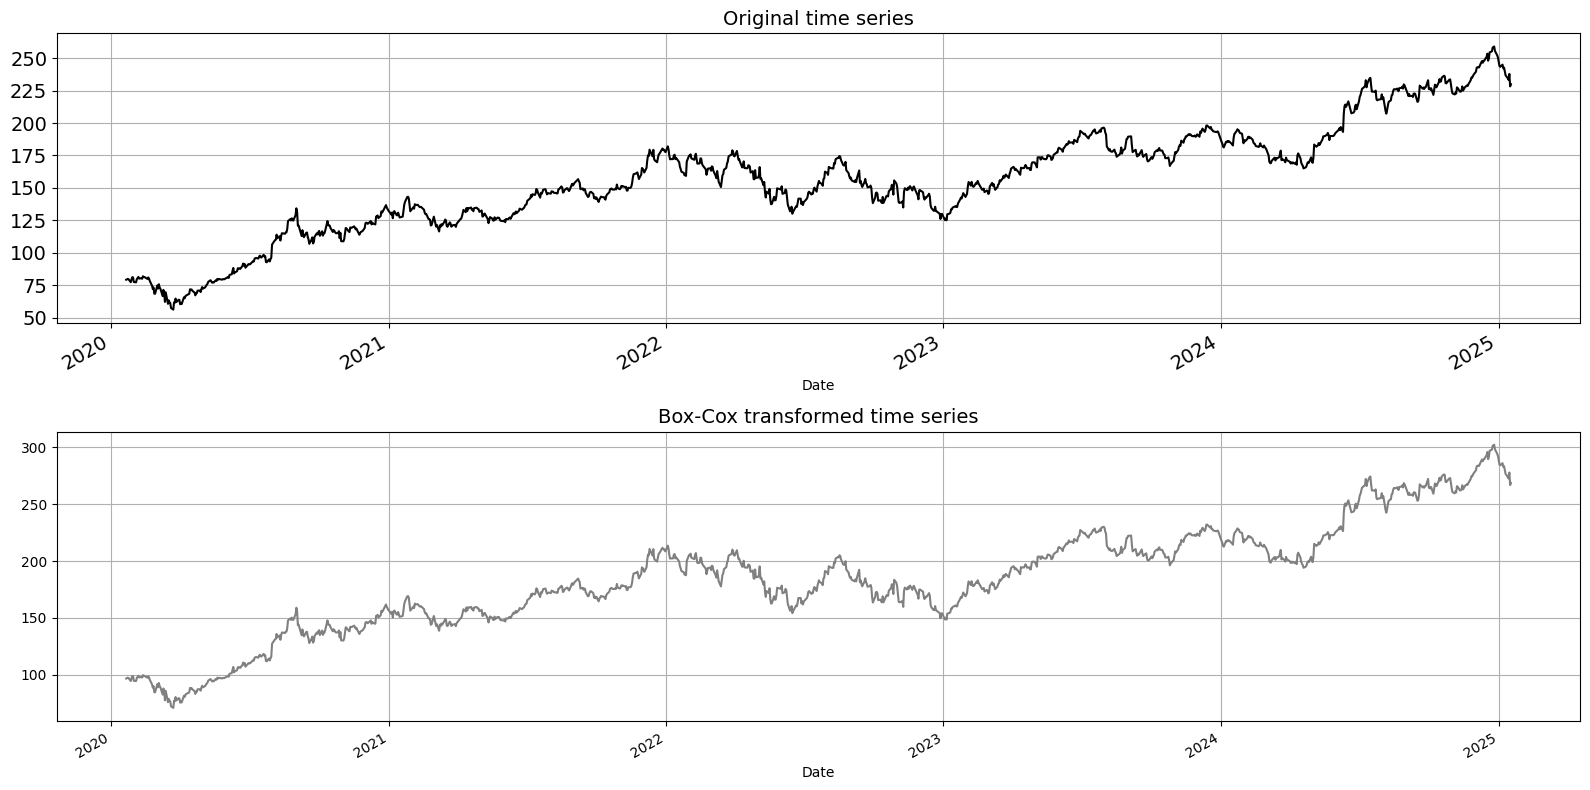

In [ ]:
# Visual check of distribution – comparison of original and transformed data

boxcox_transformed_data, boxcox_lambda = boxcox(data["close"] + 10)
boxcox_transformed_data = pd.Series(boxcox_transformed_data, index=data.index)

fig, ax = plt.subplots(2, 1, figsize=(16, 8))
data["close"].plot(ax=ax[0], color="black", fontsize=14)
ax[0].set_title("Original time series", fontsize=14)


boxcox_transformed_data.plot(
    ax=ax[1],
    color="grey",
)
ax[1].set_title("Box-Cox transformed time series", fontsize=14)

ax[0].grid()
ax[1].grid()

plt.tight_layout()
plt.show()

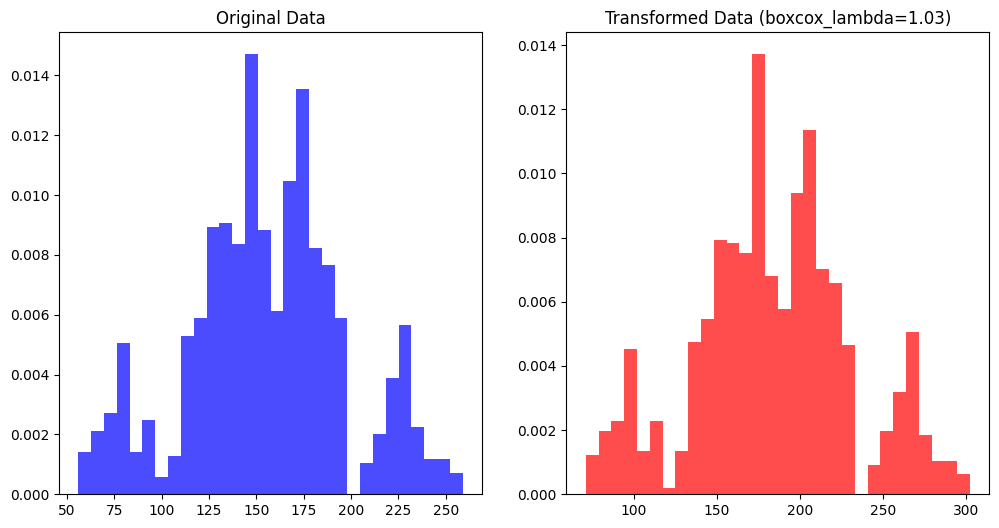

In [37]:
# Visual check of distribution – comparison of original and transformed data

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data["close"], bins=30, density=True, color='blue', alpha=0.7)
plt.title('Original Data')
plt.subplot(1, 2, 2)
plt.hist(boxcox_transformed_data, bins=30, density=True, color='red', alpha=0.7)
plt.title('Transformed Data (boxcox_lambda={:.2f})'.format(boxcox_lambda))
plt.show()

In [40]:
series = pd.Series(data["close"], index=data.index, name="Series")
training_set = series[:int(len(series) * 0.8)]
testing_set = series[int(len(series) * 0.8):]

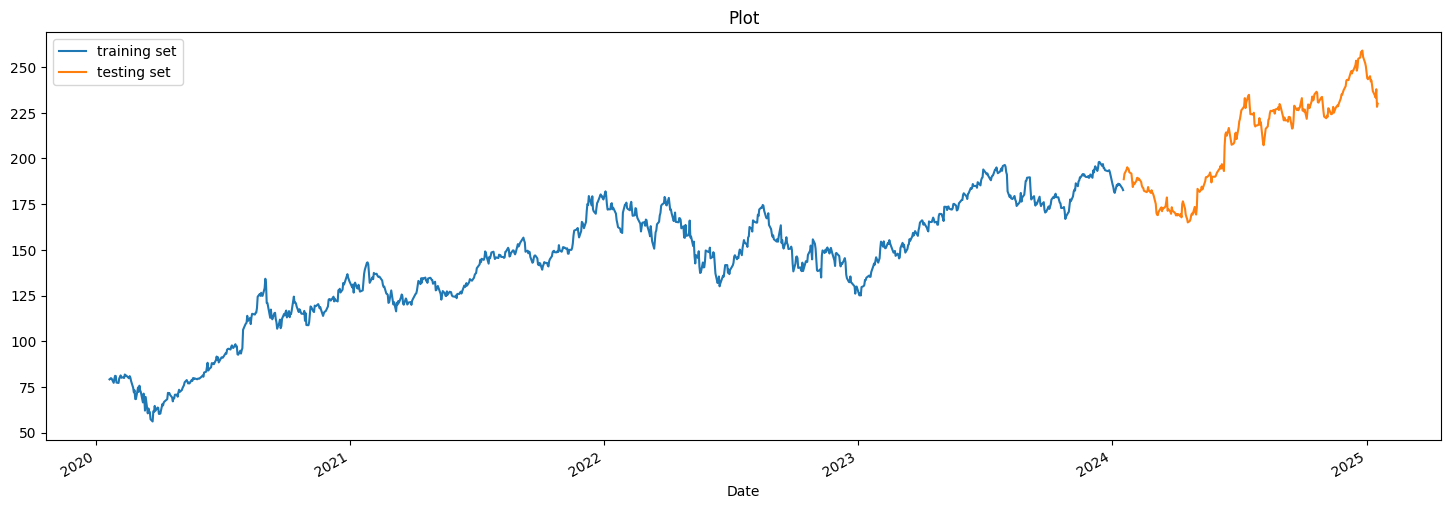

In [41]:
plt.figure(figsize=(18, 6))
plt.title("Plot")
training_set.plot(label="training set")
testing_set.plot(label="testing set")

plt.legend()
plt.show()

In [47]:
model = auto_arima(training_set)
forecast, conf_int = model.predict(n_periods=len(testing_set), return_conf_int=True, alpha=0.05)
model.summary()

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1005
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2396.897
Date:                Sun, 19 Jan 2025   AIC                           4805.795
Time:                        23:25:27   BIC                           4835.265
Sample:                             0   HQIC                          4816.994
                               - 1005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3749      0.320      1.172      0.241      -0.252       1.002
ar.L1         -1.8640      0.012   -149.320      0.000      -1.888      -1.840
ar.L2         -0.9785      0.012    -80.307      0.000      -1.002      -0.955
ma.L1          1.8627      0.016    115.417      0.000       1.831       1.894
ma.L2          0.9682      0.016     61.547      0.000       0.937       0.999
sigma2         6.9298      0.236     29.424      0.000       6.468       7.391
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):               101.45
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.08
Prob(H) (two-sided):                  0.82   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
forecast_df = pd.DataFrame({
    'Forecast': forecast,
    'Lower_CI': conf_int[:, 0],  # Lower bound of the confidence interval
    'Upper_CI': conf_int[:, 1]   # Upper bound of the confidence interval
}, index=forecast.index)

In [50]:
forecast_df

,Forecast,Lower_CI,Upper_CI
1005,183.070146,177.910652,188.229639
1006,182.782525,175.490676,190.074373
1007,183.311776,174.406299,192.217253
1008,182.981536,172.671959,193.291113
1009,183.454127,171.960407,194.947847
...,...,...,...
1252,206.999054,125.990296,288.007813
1253,207.079311,125.907495,288.251127
1254,207.201183,125.866549,288.535818
1255,207.270351,125.773109,288.767593


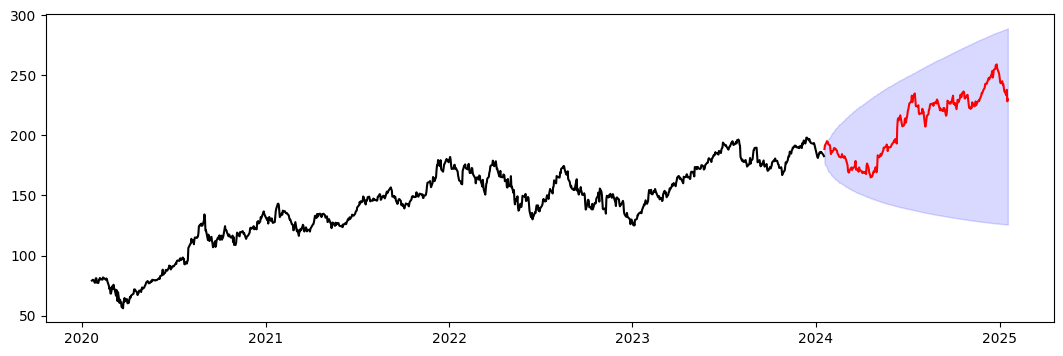

In [56]:
plt.figure(figsize=(13, 4))
plt.title("")
plt.plot(training_set, color="black", label="training set")
plt.plot(testing_set, color="red", label="testing set")
#plt.plot(forecast_df.Forecast, label="forecast", color="blue")

plt.fill_between(
    testing_set.index,
    forecast_df["Lower_CI"],
    forecast_df["Upper_CI"],
    color="b",
    alpha=0.15,
)

In [8]:
# Fetch the options chain for the selected date
options_chain = yf.Ticker(ticker).option_chain(expiration_dates[5])

# Separate calls and puts
calls = options_chain.calls
puts = options_chain.puts

calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL250221C00100000,2025-01-16 16:24:52+00:00,100.0,130.80,0.0,0.0,0.0,0.0,23,0,0.000010,True,REGULAR,USD
1,AAPL250221C00105000,2024-12-27 16:14:26+00:00,105.0,149.85,0.0,0.0,0.0,0.0,1,0,0.000010,True,REGULAR,USD
2,AAPL250221C00110000,2025-01-15 14:48:55+00:00,110.0,128.05,0.0,0.0,0.0,0.0,370,0,0.000010,True,REGULAR,USD
3,AAPL250221C00115000,2024-12-31 20:53:09+00:00,115.0,135.90,0.0,0.0,0.0,0.0,30,0,0.000010,True,REGULAR,USD
4,AAPL250221C00120000,2024-12-27 16:07:02+00:00,120.0,135.20,0.0,0.0,0.0,0.0,10,0,0.000010,True,REGULAR,USD
5,AAPL250221C00125000,2025-01-15 20:48:47+00:00,125.0,113.30,0.0,0.0,0.0,0.0,18,0,0.000010,True,REGULAR,USD
6,AAPL250221C00130000,2025-01-15 18:25:10+00:00,130.0,108.04,0.0,0.0,0.0,0.0,2,0,0.000010,True,REGULAR,USD
7,AAPL250221C00135000,2025-01-08 15:50:22+00:00,135.0,108.85,0.0,0.0,0.0,0.0,22,0,0.000010,True,REGULAR,USD
8,AAPL250221C00140000,2025-01-16 20:24:05+00:00,140.0,89.69,0.0,0.0,0.0,0.0,1,0,0.000010,True,REGULAR,USD
9,AAPL250221C00145000,2025-01-08 15:48:03+00:00,145.0,98.75,0.0,0.0,0.0,0.0,14,0,0.000010,True,REGULAR,USD


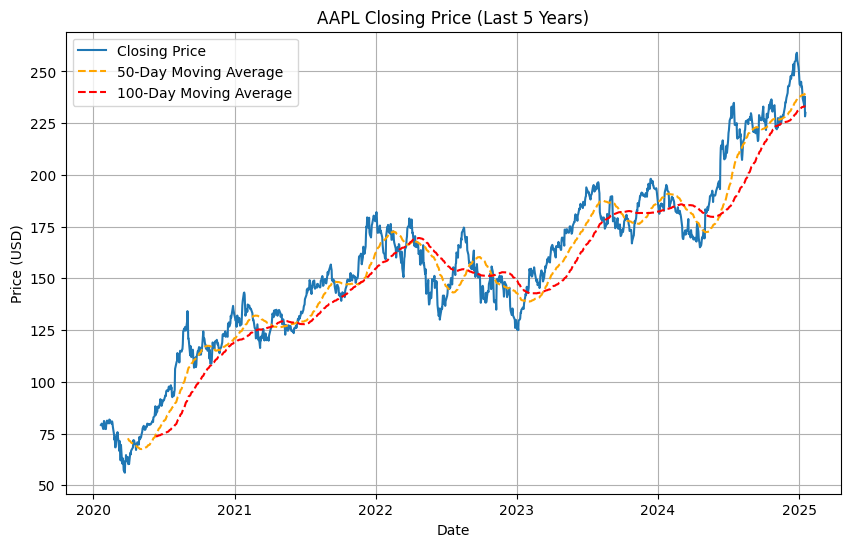

In [12]:
data['50_day_MA'] = data['close'].rolling(window=50).mean()
data['100_day_MA'] = data['close'].rolling(window=100).mean()

plt.figure(figsize=(10, 6))
plt.plot(data['close'], label='Closing Price')
plt.plot(data['50_day_MA'], label='50-Day Moving Average', color='orange', linestyle='--')
plt.plot(data['100_day_MA'], label='100-Day Moving Average', color='red', linestyle='--')
plt.title(f'AAPL Closing Price (Last 5 Years)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

In [1]:
import mibian

# Example parameters
underlying_price_today = 150
underlying_price_future = 160
strike_price_buy = 155
strike_price_sell = 165
interest_rate = 1  # Annual interest rate in %
days_to_expiry = 30  # Total days to expiration
days_elapsed = 5
implied_volatility = 20  # IV in %

# Calculate the option premiums for today and the future
call_buy_today = mibian.BS([underlying_price_today, strike_price_buy, interest_rate, days_to_expiry], volatility=implied_volatility).callPrice
call_sell_today = mibian.BS([underlying_price_today, strike_price_sell, interest_rate, days_to_expiry], volatility=implied_volatility).callPrice

call_buy_future = mibian.BS([underlying_price_future, strike_price_buy, interest_rate, days_to_expiry - days_elapsed], volatility=implied_volatility).callPrice
call_sell_future = mibian.BS([underlying_price_future, strike_price_sell, interest_rate, days_to_expiry - days_elapsed], volatility=implied_volatility).callPrice

# Calculate spread prices
debit_spread_today = call_buy_today - call_sell_today
debit_spread_future = call_buy_future - call_sell_future

# Print results
print(f"Debit Spread Price Today: ${debit_spread_today:.2f}")
print(f"Debit Spread Price in {days_elapsed} Days: ${debit_spread_future:.2f}")

Debit Spread Price Today: $1.39
Debit Spread Price in 5 Days: $4.96
